In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:44307")
client

<Client: 'tcp://127.0.0.1:44307' processes=8 threads=56, memory=755.75 GiB>

In [ ]:
# https://vinson2233.wordpress.com/2020/11/17/sklearn-vs-numpy-vs-numba-speed-comparison-evaluation-metric-and-building-linear-regression-model/

In [51]:
import xarray as xr
import glob
from pathlib import Path
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import statsmodels.api as sm

# constants

In [99]:
sel_period = slice('1980','2023')
root_path = '/sto0/data/Intermediate/S-RIP/'
xr.set_options(keep_attrs = True)
enso_lag = -4
s_year = sel_period.start
e_year = sel_period.stop

# Functions

In [75]:

def _OLS(Y):
    nt = len(Y)
    #print(Y)
    try:
        model = sm.OLS(Y,X, missing='drop')
        results = model.fit()
        resids = Y-results.predict(X)
    except:
        resids = np.array([np.nan]*nt)

    return resids

def wrap_OLS(Y):
    #print(Y.shape)

    return _OLS(Y)

def parse_time(ds):
    start_date = ds["time"].attrs["units"].split("since ")[-1].split('-')
    year = start_date[0]
    month = start_date[1]
    #print(start_date)
    #print(f'{year}-{month}-01')
    time = pd.date_range(f'{year}-{month}-01', freq="MS", periods=ds.time.shape[0])
    ds["time"] = time
    ds_sel = ds.sel(time=sel_period)
    for sel_var in ds_sel.data_vars.keys():
        da = normalize(ds_sel[sel_var])
    return da


def normalize(da):
    m = da.mean("time")
    s = da.std("time")
    return (da - m) / s

# regressor loading

In [76]:
#ds_enso = xr.open_dataset("iersst_nino3.4a_rel.nc", decode_times=False).pipe(parse_time)
#ds_enso = xr.open_dataset("imeiv2.nc", decode_times=False).pipe(parse_time)
ds_enso = xr.open_dataset("ihadisst1_nino3.4a.nc", decode_times=False).pipe(parse_time)
ds_solar = xr.open_dataset("isolarradioflux.nc", decode_times=False).pipe(parse_time)

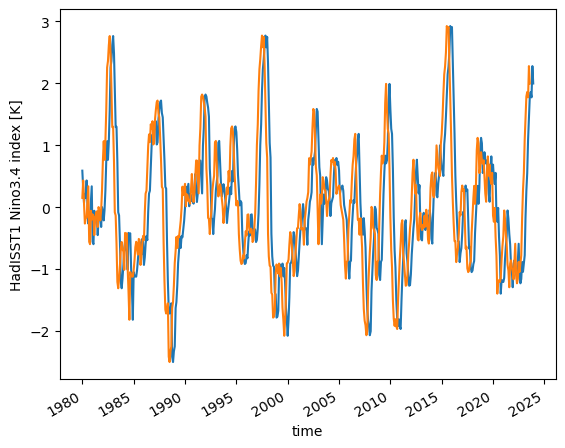

In [73]:
ds_enso.plot()
ds_enso.shift(time = -4).plot()

## QBO

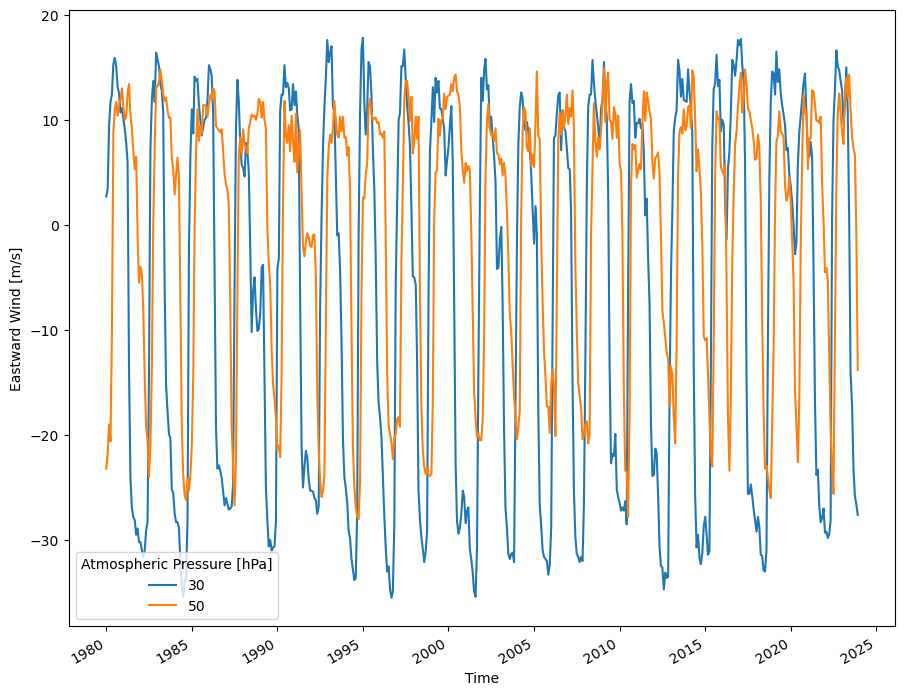

In [12]:
ds_qbo = xr.open_dataset("radiosonde_tropical_eastward_wind_195301-202501.nc")
qbo_sel = ds_qbo["u"].sel(pressure=[30, 50], time=sel_period)
qbo_sel_norm = normalize(qbo_sel)
# qbo_sel_norm.name = 'qbo'
qbo50 = qbo_sel_norm.sel(pressure=50)
qbo50.name = "qbo50"
qbo30 = qbo_sel_norm.sel(pressure=30)
qbo30.name = "qbo30"
qbo_sel.plot.line(hue="pressure", size=8)

# regression preparation

In [77]:
reg = xr.merge(
    [
        qbo50.reset_coords(drop=True), 
        qbo30.reset_coords(drop=True), 
        ds_solar, 
        ds_enso.shift(time = enso_lag),
        xr.DataArray(np.linspace(-1,1,qbo30.time.shape[0]), coords={'time': ('time',qbo30.time.values)}, name='trend')
    ],
    #join = 'left'
)
da_reg = reg.to_array()
X = sm.add_constant(reg.to_array().T.values)


# data loading

In [102]:
!ls /sto0/data/Intermediate/S-RIP/zonal/common-grid/daily/core/

ERA5  ERA5.1  JRA-3Q  JRA-55  MERRA-2


In [111]:
what = 'MERRA-2'
what = 'JRA-55'
what = 'ERA5'
what = 'JRA-3Q'
inpath = f"{root_path}zonal/common-grid/daily/core/{what}/"
infiles = sorted(Path(inpath).glob("*.nc"))
infiles

[PosixPath('/sto0/data/Intermediate/S-RIP/zonal/common-grid/daily/core/JRA-3Q/JRA-3Q_zonal_common-grid_daily_core_1947-09.nc'),
 PosixPath('/sto0/data/Intermediate/S-RIP/zonal/common-grid/daily/core/JRA-3Q/JRA-3Q_zonal_common-grid_daily_core_1947-10.nc'),
 PosixPath('/sto0/data/Intermediate/S-RIP/zonal/common-grid/daily/core/JRA-3Q/JRA-3Q_zonal_common-grid_daily_core_1947-11.nc'),
 PosixPath('/sto0/data/Intermediate/S-RIP/zonal/common-grid/daily/core/JRA-3Q/JRA-3Q_zonal_common-grid_daily_core_1947-12.nc'),
 PosixPath('/sto0/data/Intermediate/S-RIP/zonal/common-grid/daily/core/JRA-3Q/JRA-3Q_zonal_common-grid_daily_core_1948-01.nc'),
 PosixPath('/sto0/data/Intermediate/S-RIP/zonal/common-grid/daily/core/JRA-3Q/JRA-3Q_zonal_common-grid_daily_core_1948-02.nc'),
 PosixPath('/sto0/data/Intermediate/S-RIP/zonal/common-grid/daily/core/JRA-3Q/JRA-3Q_zonal_common-grid_daily_core_1948-03.nc'),
 PosixPath('/sto0/data/Intermediate/S-RIP/zonal/common-grid/daily/core/JRA-3Q/JRA-3Q_zonal_common-grid_d

In [112]:
ds = xr.open_mfdataset(
    infiles,
    parallel=True,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim=["time"],
)  # .pipe(process, deseasonalize=False)
ds = ds.sortby('time')
ds  # _wo_chem

<xarray.Dataset>
Dimensions:        (time: 28002, lat: 73, pre: 22)
Coordinates:
  * pre            (pre) int32 100000 92500 85000 70000 ... 500 300 200 100
  * lat            (lat) float64 -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
  * time           (time) datetime64[ns] 1947-09-01 1947-09-02 ... 2024-04-30
Data variables:
    z              (time, lat, pre) float32 dask.array<chunksize=(30, 73, 22), meta=np.ndarray>
    t              (time, lat, pre) float32 dask.array<chunksize=(30, 73, 22), meta=np.ndarray>
    u              (time, lat, pre) float32 dask.array<chunksize=(30, 73, 22), meta=np.ndarray>
    v              (time, lat, pre) float32 dask.array<chunksize=(30, 73, 22), meta=np.ndarray>
    w              (time, lat, pre) float32 dask.array<chunksize=(30, 73, 22), meta=np.ndarray>
    t2theta        (time, pre) float64 dask.array<chunksize=(30, 22), meta=np.ndarray>
    days_included  (time) float64 30.0 30.0 30.0 30.0 ... 30.0 30.0 30.0 30.0
Attributes:
    land_mask:           0
    author:              Patrick Martineau
    reference:           https://doi.org/10.5194/essd-10-1925-2018
    website:             https://www.jamstec.go.jp/ridinfo/
    contact_address1:    pmartineau@jamstec.go.jp
    contact_address2:    pmartineau.work@gmail.com
    source_reanalysis:   JRA-3Q
    original_file_name:  JRA-3Q_zonal_common-grid_daily_core_1947-09.nc
    data_realm:          zonal
    data_type:           core

# data preparation

In [113]:
t_monthly = ds["t"].resample(time="M").mean()#.load()
t_monthly_gb = t_monthly.groupby("time.month")
t_monthly_clim = t_monthly_gb.mean("time")
t_monthly_ano = t_monthly_gb - t_monthly_clim
t_monthly_ano

<xarray.DataArray 't' (time: 920, lat: 73, pre: 22)>
dask.array<sub, shape=(920, 73, 22), dtype=float32, chunksize=(1, 73, 22), chunktype=numpy.ndarray>
Coordinates:
  * pre      (pre) int32 100000 92500 85000 70000 60000 ... 700 500 300 200 100
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
  * time     (time) datetime64[ns] 1947-09-30 1947-10-31 ... 2024-04-30
    month    (time) int64 9 10 11 12 1 2 3 4 5 6 7 ... 6 7 8 9 10 11 12 1 2 3 4
Attributes:
    units:          K
    description:    Air temperature
    standard_name:  air_temperature
    latex_name:     $\overline{T}$

# regression

In [114]:
da_resids = xr.apply_ufunc(
    wrap_OLS,
    t_monthly_ano.sel(time = sel_period),
    input_core_dims=[['time']],
    output_core_dims = [['time']],
    dask="parallelized",
    vectorize=True,
    output_dtypes=[float], 
    dask_gufunc_kwargs = dict(allow_rechunk=True)
).load()
da_resids.name = 'resids'#.sel(time = '')
outpath = f'{root_path}{what}_volc-residuals_{s_year}-{e_year}.nc'
print(outpath)
da_resids.to_netcdf(outpath)

/sto0/data/Intermediate/S-RIP/JRA-3Q_volc-residuals_1980-2023.nc


In [126]:
infiles = sorted(Path(root_path).glob("*volc-residuals*.nc"))

ds = xr.open_mfdataset(
    infiles,
    parallel=True,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim=["rean"],
)  # .pipe(process, deseasonalize=False)
#ds = ds.sortby('time')
ds['rean'] = list(map(lambda x: x.name.split('_')[0], infiles))
ds  # _wo_chem

<xarray.Dataset>
Dimensions:  (pre: 22, lat: 73, time: 528, rean: 4)
Coordinates:
  * pre      (pre) int32 100000 92500 85000 70000 60000 ... 700 500 300 200 100
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
  * time     (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2023-12-31
    month    (time) int64 dask.array<chunksize=(528,), meta=np.ndarray>
  * rean     (rean) <U7 'ERA5' 'JRA-3Q' 'JRA-55' 'MERRA-2'
Data variables:
    resids   (rean, lat, pre, time) float64 dask.array<chunksize=(1, 73, 22, 528), meta=np.ndarray>

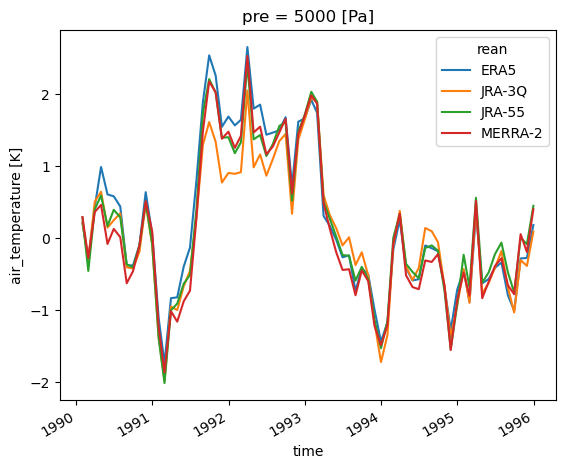

In [142]:
temp = ds['resids'].sel(pre = 5000, lat = slice(-30,30), time = slice('1990','1995')).mean('lat')
temp.plot(hue = 'rean')

Text(0, 0.5, 'R(t)')

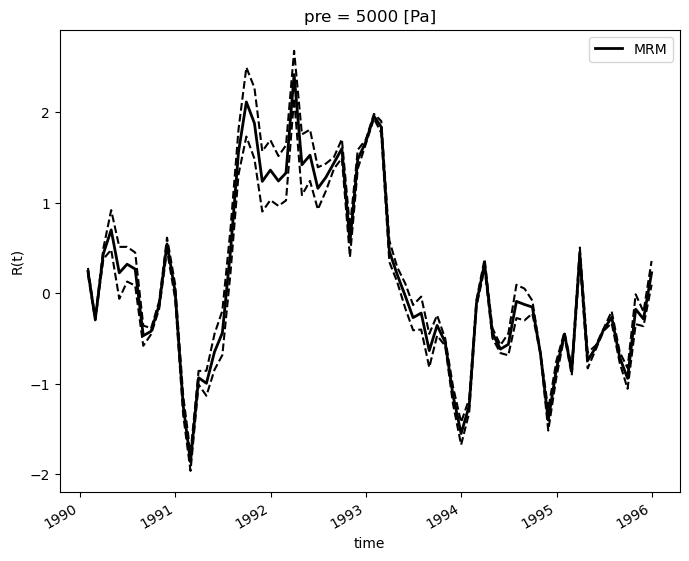

In [155]:
temp = ds['resids'].sel(
    pre = 5000, 
    lat = slice(-30,30), 
    time = slice('1990','1995'),
    rean = ['ERA5','JRA-3Q','MERRA-2']
).mean('lat')
#temp.plot(hue = 'rean')
m = temp.mean('rean')
m.plot(color = 'k', lw = 2, size = 6, label = 'MRM')
s = temp.std('rean')
u = m+s
l = m-s
u.plot(color = 'k', ls = 'dashed')
l.plot(color = 'k', ls = 'dashed')
plt.legend()
plt.ylabel('R(t)')

In [145]:
diff = ds['resids'].sel(time = slice('1991-06', '1994-06')).mean('time')-ds['resids'].sel(time = slice('1990-07', '1991-06')).mean('time')
diff

<xarray.DataArray 'resids' (rean: 4, lat: 73, pre: 22)>
dask.array<sub, shape=(4, 73, 22), dtype=float64, chunksize=(1, 73, 22), chunktype=numpy.ndarray>
Coordinates:
  * pre      (pre) int32 100000 92500 85000 70000 60000 ... 700 500 300 200 100
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
  * rean     (rean) <U7 'ERA5' 'JRA-3Q' 'JRA-55' 'MERRA-2'
Attributes:
    units:          K
    description:    Air temperature
    standard_name:  air_temperature
    latex_name:     $\overline{T}$

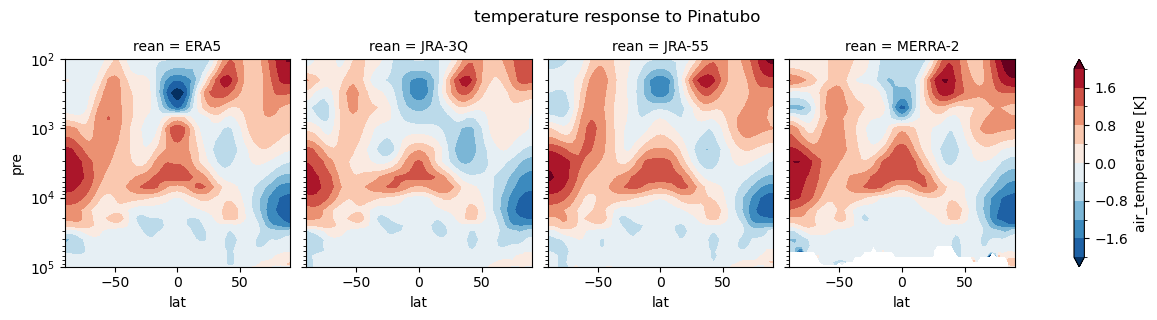

In [157]:
p = diff.plot.contourf(col = 'rean', robust = True, yincrease = False, x = 'lat', extend='both', levels = np.arange(-2,2.4,0.4))
p.fig.suptitle('temperature response to Pinatubo', y = 1.05)
plt.yscale('log')